In [8]:
import wrangle as w 
import os 
from env import get_db_url

import pandas as pd 
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing, cluster
import scipy

# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import wrangle as w
import mitosheet
import folium
from folium.plugins import FastMarkerCluster

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [37]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = w.wrangle_zillow_anew('logerror')

Using cached CSV
The following 34 columns were dropped because they were missing more than 50.0% of data: 
['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc', 'storydesc', 'typeconstructiondesc']

0 rows were dropped because they were missing more than 50.0% of data
Yearbuilt converted to age. 



## Clustering

"K-Means aims to partition observations into a predefined number of clusters (k) in which each point belongs to the cluster via proximate mean. It starts by randomly selecting k centroids and assigning the points to the closest cluster, then it updates each centroid with the mean of all points in the cluster. This algorithm is convenient when you need the get a precise number of groups, and it’s more appropriate for a small number of even clusters."

In [5]:
X_train.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'propertycountylandusecode', 'regionidzip', 'taxvaluedollarcnt',
       'taxamount', 'age', 'taxrate', 'structure_cost_per_sqft',
       'land_cost_per_sqft', 'fiscal_quarter', 'los_angeles', 'orange'],
      dtype='object')

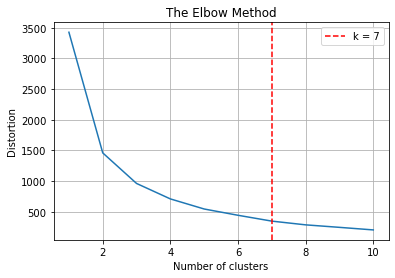

In [6]:
X = X_train[["latitude","longitude"]]
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [11]:
k = 7
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = X_train[["latitude","longitude"]]
## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
X_train[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
X_train.sample(5)

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertycountylandusecode,regionidzip,taxvaluedollarcnt,taxamount,censustractandblock,age,taxrate,structure_cost_per_sqft,land_cost_per_sqft,fiscal_quarter,los_angeles,orange,cluster,centroids
parcelid,,,,,,,,,,,,,,,,,,,
11118165,3.0,5.0,2162.0,34.434064,-118.539860,0101,96377,508000.0,6859.71,6.037920e+13,45,1.35,109.805735,40.993789,3,1,0,6,0
14487145,2.0,4.0,1775.0,33.624329,-117.654872,122,96995,91880.0,948.48,6.059032e+13,44,1.03,38.922254,3.247329,1,0,1,3,0
17279762,1.5,3.0,1377.0,34.218400,-118.864824,1110,96383,280167.0,3035.34,6.111006e+13,44,1.08,83.251271,13.268938,2,0,0,0,0
12873335,2.0,3.0,1072.0,34.074314,-117.726039,0100,96507,342000.0,4208.97,6.037403e+13,60,1.23,71.828358,43.816138,2,1,0,5,0
10985506,3.0,4.0,1539.0,34.275244,-118.419763,0100,96361,236330.0,3027.87,6.037104e+13,56,1.28,63.896036,22.117968,1,1,0,6,0


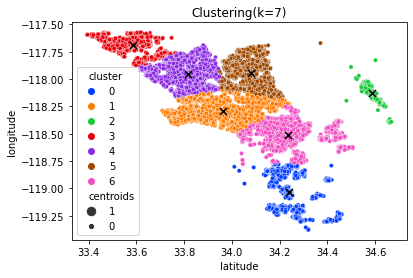

In [14]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="latitude", y="longitude", data=X_train, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering(k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

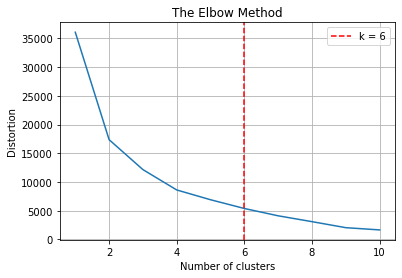

In [45]:
X = X_train_scaled[["bedroomcnt","bathroomcnt"]]
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [46]:
k = 7
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = X_train[["bedroomcnt","bathroomcnt"]]
## clustering
dtf_X = X.copy()
dtf_X["clusterbnb"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("clusterbnb", axis=1).values)
dtf_X["centroidsbnb"] = 0
for i in closest:
    dtf_X["centroidsbnb"].iloc[i] = 1
## add clustering info to the original dataset
X_train[["clusterbnb","centroidsbnb"]] = dtf_X[["clusterbnb","centroidsbnb"]]
X_train.sample(5)

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertycountylandusecode,regionidzip,taxvaluedollarcnt,taxamount,censustractandblock,age,taxrate,structure_cost_per_sqft,land_cost_per_sqft,fiscal_quarter,los_angeles,orange,clusterbnb,centroidsbnb
parcelid,,,,,,,,,,,,,,,,,,,
14037172,3.0,5.0,2660.0,33.739986,-118.009295,122,96965,508121.0,5871.98,6.059100e+13,21,1.16,103.419173,44.761045,2,0,1,2,0
12953654,2.0,3.0,1344.0,34.053198,-117.939014,0100,96523,215510.0,2713.07,6.037407e+13,62,1.26,65.587798,12.463059,1,1,0,1,0
11460195,1.0,3.0,1275.0,33.974494,-118.399385,0100,96026,96263.0,1264.97,6.037277e+13,66,1.31,24.675294,10.482368,2,1,0,5,0
14382472,2.0,3.0,1494.0,33.591844,-117.678326,122,96971,254519.0,2569.10,6.059042e+13,43,1.01,69.542169,26.425088,1,0,1,1,0
13918349,2.0,3.0,1521.0,33.856469,-117.931313,122,97040,432310.0,5029.38,6.059012e+13,59,1.16,50.322156,55.115414,2,0,1,1,0


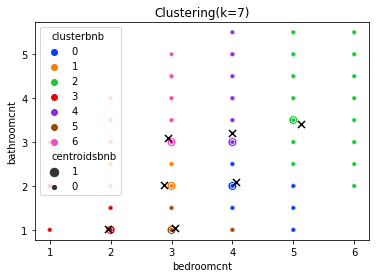

In [48]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="bedroomcnt", y="bathroomcnt", data=X_train, 
                palette=sns.color_palette("bright",k),
                hue='clusterbnb', size="centroidsbnb", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering(k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

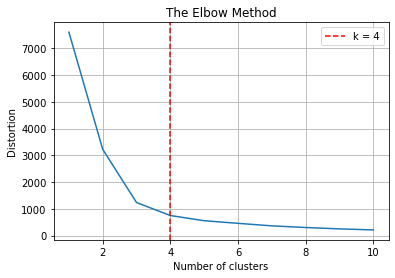

In [36]:
['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'propertycountylandusecode', 'regionidzip',
       'taxvaluedollarcnt', 'taxamount', 'censustractandblock', 'age',
       'taxrate', 'structure_cost_per_sqft', 'land_cost_per_sqft',
       'fiscal_quarter', 'los_angeles', 'orange']

In [29]:
k = 7
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = X_train[["latitude","longitude"]]
## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
X_train[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
X_train.sample(5)

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertycountylandusecode,regionidzip,taxvaluedollarcnt,taxamount,censustractandblock,...,taxrate,structure_cost_per_sqft,land_cost_per_sqft,fiscal_quarter,los_angeles,orange,cluster,centroids,clustercost,centroidscost
parcelid,,,,,,,,,,,,,,,,,,,,,
10766290,2.0,4.0,1602.0,34.213428,-118.564669,0100,96341,83003.0,1114.12,6.037134e+13,...,1.34,37.994382,3.367204,3,1,0,6,0,5,0
14280676,3.5,4.0,2743.0,33.642125,-117.899197,122,96978,1177495.0,12796.32,6.059063e+13,...,1.09,66.765950,104.889873,2,0,1,4,0,2,0
12782320,2.0,3.0,2074.0,33.996321,-118.052436,0100,96169,153602.0,2185.49,6.037501e+13,...,1.42,61.192382,3.544827,3,1,0,5,0,2,0
12450755,2.0,4.0,1200.0,33.868130,-118.152183,0101,96239,395287.0,4746.62,6.037570e+13,...,1.20,136.616667,38.264472,2,1,0,1,0,0,0
10820776,2.0,2.0,1244.0,34.216063,-118.507625,0100,96415,406100.0,4974.09,6.037131e+13,...,1.22,97.934084,46.678161,1,1,0,6,0,0,0


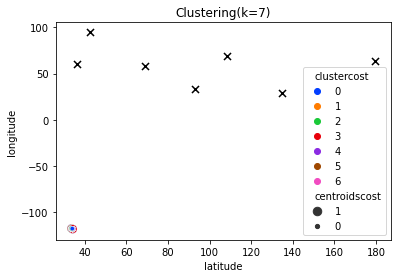

In [32]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="latitude", y="longitude", data=X_train, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering(k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

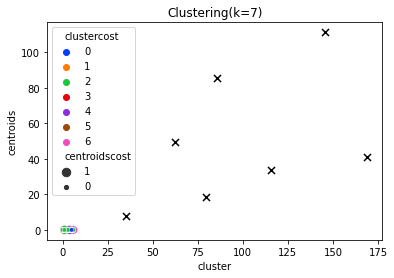

In [27]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x='cluster', y='centroids', data=X_train, 
                palette=sns.color_palette("bright",k),
                hue='clustercost', size="centroidscost", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering(k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

#'structure_cost_per_sqft','land_cost_per_sqft'

In [41]:
def scale_data(X_train, X_validate, X_test, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    
    Target is not scaled.
    
    columns_to_scale was originally used to check whether los_angeles and orange would cause trouble
    '''
    columns_to_scale = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'propertycountylandusecode', 'regionidzip',
       'taxvaluedollarcnt', 'taxamount', 'censustractandblock', 'age',
       'taxrate', 'structure_cost_per_sqft', 'land_cost_per_sqft',
       'fiscal_quarter', 'los_angeles', 'orange']
    
    X_train_scaled = X_train.copy()
    X_validate_scaled = X_validate.copy()
    X_test_scaled = X_test.copy()
    
    scaler = StandardScaler()
    scaler.fit(X_train_scaled[columns_to_scale])
    
    X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_validate_scaled[columns_to_scale] = scaler.transform(X_validate[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    
    if return_scaler:
        return scaler, X_train_scaled, X_validate_scaled, X_test_scaled
    else:
        return X_train_scaled, X_validate_scaled, X_test_scaled

In [39]:
X_train.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'propertycountylandusecode', 'regionidzip',
       'taxvaluedollarcnt', 'taxamount', 'censustractandblock', 'age',
       'taxrate', 'structure_cost_per_sqft', 'land_cost_per_sqft',
       'fiscal_quarter', 'los_angeles', 'orange'],
      dtype='object')

In [42]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test)

In [43]:
X_train_scaled

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertycountylandusecode,regionidzip,taxvaluedollarcnt,taxamount,censustractandblock,age,taxrate,structure_cost_per_sqft,land_cost_per_sqft,fiscal_quarter,los_angeles,orange
parcelid,,,,,,,,,,,,,,,,,
17137577,-0.226605,0.814376,0.105579,0.908470,-2.223792,2.986695,1.416044,0.610863,0.401936,2.714374,-1.668933,-1.094812,2.691860,-0.285659,-1.326191,-1.324592,-0.596436
14475482,0.395783,-0.375678,0.694879,-1.816471,1.499098,-0.279087,1.173913,1.216161,0.842762,0.383154,-0.976756,-1.430725,-0.094444,2.054033,-0.034523,-1.324592,1.676626
11189106,1.018170,0.814376,0.675046,2.510775,0.086457,-0.351734,2.034248,-0.420304,-0.143949,-0.564245,-1.471168,1.536506,0.423630,-0.857977,-1.326191,0.754949,-0.596436
17211323,0.395783,2.004430,0.813872,0.819089,-1.784421,2.986695,-0.402508,1.002310,0.742227,2.714428,-0.284579,-1.150798,2.626100,-0.289138,-0.034523,-1.324592,-0.596436
13914309,-0.226605,-0.375678,-0.724540,-0.654641,0.742006,-0.279087,1.292403,-1.265979,-1.255294,0.382216,0.259274,2.544245,-1.461390,-1.092176,-0.034523,-1.324592,1.676626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12247959,-0.226605,-0.375678,-0.973860,-0.657331,-0.217270,-0.351734,-1.118595,-1.235031,-1.235740,-0.592006,0.308716,1.760448,-1.330913,-1.003343,-1.326191,0.754949,-0.596436
11986448,-1.471381,-1.565732,-0.765621,0.256526,-0.404830,-0.351734,-1.314360,-0.568057,-0.559570,-0.595446,1.693070,-0.031088,1.035639,-0.690289,-1.326191,0.754949,-0.596436
12047357,2.262946,0.814376,1.560413,0.736032,-0.038223,-0.351734,-0.546756,1.512291,1.297766,-0.591584,-1.916139,-0.982841,1.230621,-0.059789,-0.034523,0.754949,-0.596436


In [8]:
import mitosheet
mitosheet.sheet(X_train_scaled, analysis_to_replay="id-nnxxkfrlxo")

MitoWidget(analysis_data_json='{"analysisName": "id-nnxxkfrlxo", "analysisToReplay": null, "code": [], "stepSu…

In [8]:
type(X_train_scaled)

pandas.core.frame.DataFrame

Text(0, 0.5, 'Inertia')

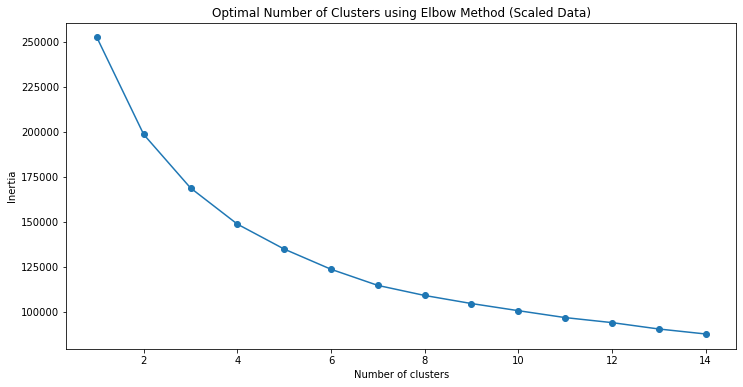

In [8]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(X_train_scaled)
    sse.append([k, km.inertia_])
    
oca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [9]:
df_scale2 = X_train_scaled.copy()
kmeans_scale = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(df_scale2)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(df_scale2, kmeans_scale.labels_, metric='euclidean')))
labels_scale = kmeans_scale.labels_
clusters_scale = pd.concat([df_scale2, pd.DataFrame({'cluster_scaled':labels_scale})], axis=1)

KMeans Scaled Silhouette Score: 0.26401977184226916


/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


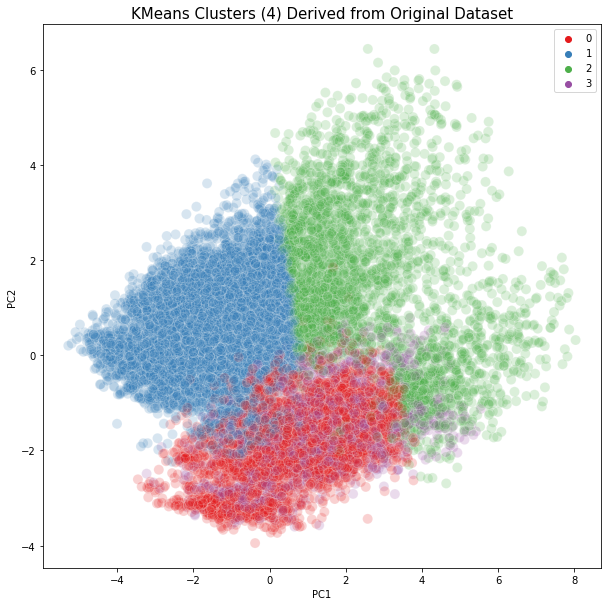

In [10]:
pca2 = PCA(n_components=3).fit(df_scale2)
pca2d = pca2.transform(df_scale2)
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_scale, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (4) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

The value of the silhouette coefﬁcient is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.    
So this is a low score. 

# Perform Dimensionality Reduction with Principal Components Analysis

In [11]:
def pca_data(X_train_scaled, X_validate_scaled, X_test_scaled, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    
    Target is not scaled.
    
    columns_to_scale was originally used to check whether los_angeles and orange would cause trouble
    '''
    columns_to_scale = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'lotsizesquarefeet', 'propertycountylandusecode', 'regionidcity',
       'regionidzip', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'age', 'taxrate',
       'structure_cost_per_sqft', 'land_cost_per_sqft', 'fiscal_quarter',
       'los_angeles', 'orange']
    
    X_train_pca = X_train_scaled.copy()
    X_validate_pca = X_validate_scaled.copy()
    X_test_pca = X_test_scaled.copy()
    
    scaler = PCA()
    scaler.fit(X_train_pca[columns_to_scale])
    
    X_train_pca[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_validate_pca[columns_to_scale] = scaler.transform(X_validate[columns_to_scale])
    X_test_pca[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    
    if return_scaler:
        return scaler, X_train_pca, X_validate_pca, X_test_pca
    else:
        return X_train_pca, X_validate_pca, X_test_pca

In [12]:
X_train_pca, X_validate_pca, X_test_pca = pca_data(X_train_scaled, X_validate_scaled, X_test_scaled)

In [13]:
X_train_pca

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,propertycountylandusecode,regionidcity,regionidzip,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,age,taxrate,structure_cost_per_sqft,land_cost_per_sqft,fiscal_quarter,los_angeles,orange
parcelid,,,,,,,,,,,,,,,,,,
17137577,447343.538096,145462.807763,-38819.564061,17063.707531,51520.876532,26593.247511,67220.471804,-86360.584208,86389.416654,31223.498507,64386.417270,44729.423513,127261.904976,-291166.051734,-158401.244431,-368226.251191,10492.929514,-213826.050262
14475482,563287.901048,279210.458444,-166967.297281,-60013.509843,5847.266160,15951.218414,143002.578789,-38372.180592,222432.064146,-4023.601002,-46025.523228,43661.488188,80004.653567,-406273.461898,69059.043716,-533820.466839,20863.307011,-192893.374402
11189106,232182.390846,38069.546155,-9789.467968,25613.009054,41071.776363,18814.589083,29162.547680,-65942.879437,32776.955784,27521.037076,46170.157040,57254.834962,86890.823670,-140302.971403,-126080.210715,-173142.727578,4246.590503,-120914.683021
17211323,529861.194684,177889.858884,-31699.881773,21194.584063,41016.148860,27812.130037,60130.322830,-108106.766263,97251.862361,39328.159758,89200.752964,38037.619687,153763.122891,-344265.204847,-207658.773983,-434221.223272,12096.649622,-260565.038063
13914309,51586.522448,-26856.728508,-23880.072185,9851.279319,20484.574571,8133.929760,23444.988042,-27349.284441,22791.932480,11590.669760,-11278.681894,69030.727083,27793.567278,-24783.075713,-15591.010969,-32700.245037,928.821549,-18642.808872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12247959,57044.244184,-21464.378852,-26027.344558,7752.469341,11433.675350,6644.650671,17006.384757,-28597.187838,27911.465693,11615.935624,-11521.135718,68009.995883,28447.369702,-30209.052132,-14053.843302,-39063.295555,1190.862027,-20776.208282
11986448,197788.457962,38413.427300,-27105.692459,11213.040231,15225.735636,12083.048132,26277.626111,-53816.009634,49622.133598,20423.524831,18806.379859,58835.395863,66008.176696,-123876.043459,-72853.329407,-156431.073558,4532.228787,-92588.022332
12047357,632971.274837,264551.324875,-101492.379068,-17379.028712,41160.506748,27715.797682,123473.513270,-84570.042953,170058.723622,21404.701027,36820.771962,35305.440144,137486.517047,-431322.762600,-99455.531649,-555781.927607,18850.770078,-268300.484892


Text(0.5, 1.0, 'StandardFollowedbyPCA')

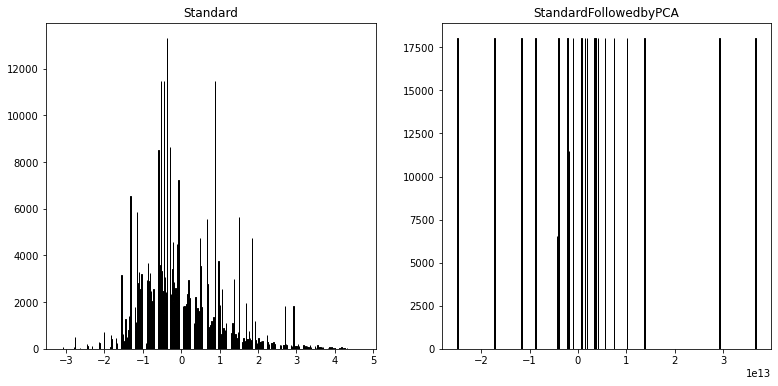

In [21]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Standard')
plt.subplot(122)
plt.hist(X_train_pca, bins=25, ec='black')
plt.title('StandardFollowedbyPCA')

In [ ]:
X_train_pca

In [15]:
import mitosheet
mitosheet.sheet(X_train_pca, analysis_to_replay="id-ijtkovdoau")

MitoWidget(analysis_data_json='{"analysisName": "id-ijtkovdoau", "analysisToReplay": null, "code": [], "stepSu…